In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
from src.utils.Contact_Matrix import matrix_scaling
from src.utils.Contact_Matrix import create_contact_matrix
from src.utils.distributions import my_beta_asymmetric

import pandas as pd
import matplotlib.pyplot as plt


In [ ]:

def extract_behavior_distribution(df, behavior_type):
    """
    Extract behavior distribution from survey data.
    
    Args:
        df: DataFrame with survey data
        behavior_type: Type of behavior ("masks", "testing", or "vacc")
        
    Returns:
        Normalized behavior distribution as a numpy array
    """
    # Clean data
    df_clean = df.dropna(subset=[f'{behavior_type}_self'])
    
    # Extract self-reported behavior
    self_behavior = df_clean[f'{behavior_type}_self'].astype(int)
    
    # Count occurrences of each behavior level (1-5)
    n_bins = 5
    behavior_vector = np.zeros(n_bins)
    for i in range(n_bins):
        behavior_vector[i] = np.sum(self_behavior == i+1)
    
    # Normalize to get distribution
    behavior_vector = behavior_vector / np.sum(behavior_vector)
    
    return behavior_vector


def generate_raw_matrix(df, behavior_type):
    """
    Args:
        df: DataFrame with survey data
        behavior_type: Type of behavior ("masks", "testing", or "vacc")
        
    Returns:
        Raw contact matrix
    """
    n_bins = 5
    
    # Clean data
    df_clean = df.dropna(subset=[f'{behavior_type}_self'])
    self_behavior = df_clean[f'{behavior_type}_self'].astype(int)
    
    # Generate raw contact matrix
    contact_matrix = np.zeros((n_bins, n_bins))
    
    # Define columns based on behavior type
    if behavior_type == "vacc":
        cols = [f'{behavior_type}_others0{i+1}' for i in range(n_bins)]
    else:
        cols = [
            f'{behavior_type}_others_never', 
            f'{behavior_type}_others_sometimes',
            f'{behavior_type}_others_half',
            f'{behavior_type}_others_often',
            f'{behavior_type}_others_always'
        ]
    
    # Fill contact matrix
    for i, row in df_clean.iterrows():
        self_idx = int(row[f'{behavior_type}_self']) - 1
        for j, col in enumerate(cols):
            if pd.notna(row[col]):
                contact_matrix[self_idx, j] += row[col]
    
    return contact_matrix


def generate_normalized_matrix(raw_matrix, behavior_distribution):
    """
    Generate a normalized contact matrix following the process:
    1. Normalize by population distribution
    2. Symmetrize the matrix
    3. Apply Sinkhorn normalization
    4. Scale by the number of bins
    
    Args:
        raw_matrix: Raw contact matrix
        behavior_distribution: Distribution of behaviors in the population
        
    Returns:
        Normalized contact matrix
    """
    # Ensure inputs are numpy arrays
    M0 = np.array(raw_matrix)
    distribution = np.array(behavior_distribution)
    
    # Step 1: Normalize by population
    M1 = (M0.T / distribution).T
    
    # Step 2: Symmetrize
    M2 = 0.5 * (M1 + M1.T)
    
    # Step 3: Apply Sinkhorn normalization
    M2_jax = jnp.array(M2)  # Convert to JAX array for matrix_scaling
    M_S2, _, _ = matrix_scaling(M2_jax, max_iters=5000, threshold=1e-8)
    
    # Step 4: Scale by number of bins (assuming 5x5 matrix)
    n_bins = M0.shape[0]
    M_final = np.array(M_S2)
    
    return M_final

def matrix_l2_distance(matrix_a, matrix_b):
    """
    Calculate the L2 norm (Frobenius norm) between two matrices.
    
    Args:
        matrix_a: First matrix
        matrix_b: Second matrix of the same shape
        
    Returns:
        The L2/Frobenius norm of the difference between the matrices
    """
    # Ensure matrices are numpy arrays
    a = np.array(matrix_a)
    b = np.array(matrix_b)
    
    # Calculate the difference
    diff = a - b
    
    # Compute the Frobenius norm (L2 norm)
    return np.sqrt(np.sum(diff * diff))

def plot_contact_matrix(matrix, ax=None, title=None, cmap='viridis', figsize=(6, 5), save_path=None):
    """
    Plot a contact matrix as a heatmap with values displayed in each cell.
    
    Args:
        matrix: 5x5 numpy array to visualize
        ax: Matplotlib axis to plot on (if None, creates a new figure)
        title: Optional title for the plot
        cmap: Colormap to use
        figsize: Figure size as (width, height) - only used if ax is None
        save_path: Path to save the figure (if None, figure is not saved)
        
    Returns:
        The matplotlib axis object with the plot
    """
    # Create figure if ax not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    # Plot heatmap
    im = ax.imshow(matrix, cmap=cmap)
    
    # Add colorbar
    #plt.colorbar(im, ax=ax)
    
    # Set ticks
    ax.set_xticks(range(5))
    ax.set_xticklabels(range(1, 6))
    ax.set_yticks(range(5))
    ax.set_yticklabels(range(1, 6))
    
    # Add title if provided
    if title:
        ax.set_title(title)
    
    # Add text with the value in each cell
    for i in range(5):
        for j in range(5):
            # Format value to 2 decimal places
            value = matrix[i, j]
            text = f"{value:.2f}" if value != 0 else "0"
            
            # Determine text color based on background darkness
            color_val = (value - np.min(matrix)) / (np.max(matrix) - np.min(matrix) + 1e-8)
            text_color = 'black' if color_val > 0.5 else 'white'
            
            # Add text to cell
            ax.text(j, i, text, ha='center', va='center', 
                   color=text_color, fontsize=9)
    
    return ax

def get_confidence_interval(x_values, error_curve, percent_variation=10):
    # Find the minimum error and its index
    min_error = np.min(error_curve)
    optimal_x = x_values[np.argmin(error_curve)]

    # find all the points that are between min_error and min_error * (1 + percent_variation / 100)
    threshold_error = min_error * (1 + percent_variation / 100)

    fig, axs = plt.subplots(1, 1, figsize=(12, 6))
    axs.plot(error_curve, label='Error Curve')
    axs.plot(threshold_error * np.ones_like(error_curve), label='Threshold Error', linestyle='--')

    axs.axvline(x=np.argmin(error_curve), color='r', linestyle='--', label='Optimal Point')
    axs.axhline(y=min_error, color='g', linestyle='--', label='Minimum Error')
    axs.set_xlabel('x values')
    axs.set_ylabel('Error')
    indices = np.where(error_curve <= threshold_error)[0]

    min_x = x_values[indices[0]]
    max_x = x_values[indices[-1]]
    
    return (min_x, optimal_x, max_x)

In [3]:
csv_path = 'data_homophily.csv'
df = pd.read_csv(csv_path)

masks_distribution = extract_behavior_distribution(df, "masks")
testing_distribution = extract_behavior_distribution(df, "testing")
vacc_distribution = extract_behavior_distribution(df, "vacc")

print("Masks behavior distribution:", masks_distribution)
print("Testing behavior distribution:", testing_distribution)
print("Vaccination behavior distribution:", vacc_distribution)


M_normalized = generate_normalized_matrix(generate_raw_matrix(df, "masks"), masks_distribution)
T_normalized = generate_normalized_matrix(generate_raw_matrix(df, "testing"), testing_distribution)
V_normalized = generate_normalized_matrix(generate_raw_matrix(df, "vacc"), vacc_distribution)

print("Normalized masks matrix row sums:", np.sum(M_normalized, axis=1))
print("Normalized masks matrix column sums:", np.sum(M_normalized, axis=0))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Masks behavior distribution: [0.03462604 0.08033241 0.10249307 0.35526316 0.42728532]
Testing behavior distribution: [0.18635171 0.29855643 0.15419948 0.18569554 0.17519685]
Vaccination behavior distribution: [0.18458418 0.10141988 0.13455037 0.23123732 0.34820825]
Normalized masks matrix row sums: [1.0000001  1.         1.         0.99999994 0.99999994]
Normalized masks matrix column sums: [0.99999994 1.         0.99999994 1.         1.        ]


In [9]:
h_range = np.linspace(1, 3, 100)

Errors = np.zeros((len(h_range), 3))

for i, h in enumerate(h_range):
    C = create_contact_matrix(5, h)

    Errors[i, 0] = matrix_l2_distance(C/5, M_normalized)
    Errors[i, 1] = matrix_l2_distance(C/5, T_normalized)
    Errors[i, 2] = matrix_l2_distance(C/5, V_normalized)


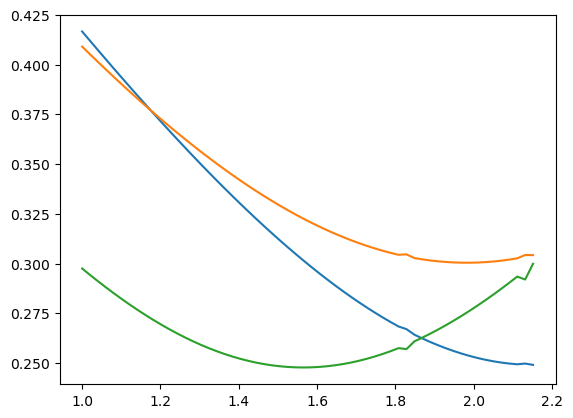

In [10]:
plt.plot(h_range,Errors[:, 0], label='Masks')
plt.plot(h_range,Errors[:, 1], label='Testing')
plt.plot(h_range,Errors[:, 2], label='Vaccination')

IndexError: index 0 is out of bounds for axis 0 with size 0

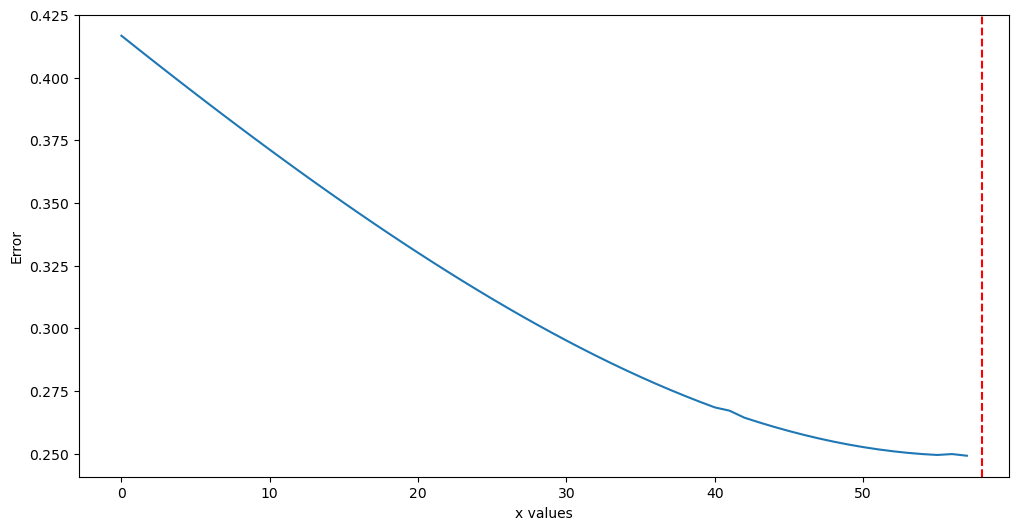

In [11]:
MASKS =  get_confidence_interval(h_range, Errors[:, 0], percent_variation=10)
TESTING = get_confidence_interval(h_range, Errors[:, 1], percent_variation=10)
VACC =   get_confidence_interval(h_range, Errors[:, 2], percent_variation=10)

In [64]:
print(f"MASKS: optimal={MASKS[1]:.2f}, interval=[{MASKS[0]:.2f}, {MASKS[2]:.2f}]")
print(f"TESTING: optimal={TESTING[1]:.2f}, interval=[{TESTING[0]:.2f}, {TESTING[2]:.2f}]")
print(f"VACC: optimal={VACC[1]:.2f}, interval=[{VACC[0]:.2f}, {VACC[2]:.2f}]")

NameError: name 'MASKS' is not defined

In [12]:
import numpy as np
import jax.numpy as jnp
import jax
from functools import partial
from typing import Tuple, Callable, List, Dict, Any, Optional

def bootstrap_sample(data: np.ndarray, n_samples: int = 1000) -> List[np.ndarray]:
    """
    Generate bootstrap samples from data.
    
    Args:
        data: Original data array
        n_samples: Number of bootstrap samples to generate
        
    Returns:
        List of bootstrap samples
    """
    n = len(data)
    indices = np.random.randint(0, n, size=(n_samples, n))
    return [data[idx] for idx in indices]

def fit_distribution_to_sample(
    sample: np.ndarray, 
    fitting_function: Callable[[np.ndarray, np.ndarray], float], 
    param_ranges: List[np.ndarray]
) -> Tuple[float, ...]:
    """
    Find best fitting parameters for a given sample.
    
    Args:
        sample: Data sample
        fitting_function: Function that computes error for parameters and sample
        param_ranges: List of arrays with parameter values to search
        
    Returns:
        Tuple of best fitting parameters
    """
    best_error = float('inf')
    best_params = None
    
    # Create mesh grid for all parameter combinations
    param_mesh = np.meshgrid(*param_ranges, indexing='ij')
    param_combinations = np.column_stack([p.flatten() for p in param_mesh])
    
    # Vectorize fitting function if possible
    if hasattr(fitting_function, '__jit__'):
        errors = []
        for params in param_combinations:
            error = fitting_function(params, sample)
            errors.append(error)
        errors = np.array(errors)
    else:
        # Fall back to loop if function can't be vectorized
        errors = np.array([fitting_function(params, sample) for params in param_combinations])
    
    # Find best parameters
    best_idx = np.argmin(errors)
    best_params = tuple(param_combinations[best_idx])
    
    return best_params

def bootstrap_parameters(
    data: np.ndarray,
    fitting_function: Callable,
    param_ranges: List[np.ndarray],
    n_bootstrap: int = 1000
) -> np.ndarray:
    """
    Perform bootstrap to estimate parameter uncertainty.
    
    Args:
        data: Original data array
        fitting_function: Function that computes error for parameters and sample
        param_ranges: List of arrays with parameter values to search
        n_bootstrap: Number of bootstrap samples
        
    Returns:
        Array of best parameters for each bootstrap sample
    """
    # Generate bootstrap samples
    samples = bootstrap_sample(data, n_bootstrap)
    
    # Fit parameters to each sample
    bootstrap_params = []
    for sample in samples:
        params = fit_distribution_to_sample(sample, fitting_function, param_ranges)
        bootstrap_params.append(params)
    
    return np.array(bootstrap_params)

def calculate_confidence_region(
    bootstrap_params: np.ndarray, 
    confidence_level: float = 0.95
) -> Dict[str, Any]:
    """
    Calculate confidence region from bootstrap parameters.
    
    Args:
        bootstrap_params: Array of parameter sets from bootstrap
        confidence_level: Confidence level (0-1)
        
    Returns:
        Dictionary with confidence region information
    """
    n_params = bootstrap_params.shape[1]
    n_samples = bootstrap_params.shape[0]
    
    # Calculate median parameters (more robust than mean)
    median_params = np.median(bootstrap_params, axis=0)
    
    # Calculate distance of each bootstrap sample from the median
    distances = np.sqrt(np.sum((bootstrap_params - median_params)**2, axis=1))
    
    # Find distance threshold for the specified confidence level
    threshold_idx = int(n_samples * confidence_level)
    sorted_distances = np.sort(distances)
    threshold = sorted_distances[threshold_idx]
    
    # Identify samples within the confidence region
    in_region = distances <= threshold
    region_samples = bootstrap_params[in_region]
    
    # Calculate confidence intervals for each parameter
    confidence_intervals = []
    for i in range(n_params):
        param_values = bootstrap_params[:, i]
        lower = np.percentile(param_values, (1 - confidence_level) * 100 / 2)
        upper = np.percentile(param_values, 100 - (1 - confidence_level) * 100 / 2)
        confidence_intervals.append((lower, median_params[i], upper))
    
    return {
        "median_params": median_params,
        "confidence_intervals": confidence_intervals,
        "region_samples": region_samples,
        "threshold": threshold,
        "confidence_level": confidence_level
    }

# Function specifically for beta distribution fitting
def fit_beta_to_distribution(
    data: np.ndarray,
    a_range: np.ndarray,
    b_range: np.ndarray,
    n_bootstrap: int = 1000,
    confidence_level: float = 0.95
) -> Dict[str, Any]:
    """
    Fit beta distribution to data with bootstrap uncertainty estimation.
    
    Args:
        data: Observed distribution
        a_range: Range of 'a' parameter values to search
        b_range: Range of 'b' parameter values to search
        n_bootstrap: Number of bootstrap samples
        confidence_level: Confidence level (0-1)
        
    Returns:
        Dictionary with fitting results and uncertainty
    """
    # Define error function for beta distribution
    @jax.jit
    def beta_error(params, sample):
        a, b = params
        n_bins = len(sample)
        beta_dist = my_beta_asymmetric(a, b, n_bins)
        return jnp.sqrt(jnp.sum((beta_dist - sample)**2))
    
    # Fit to original data first
    original_params = fit_distribution_to_sample(data, beta_error, [a_range, b_range])
    
    # Perform bootstrap
    bootstrap_params = bootstrap_parameters(data, beta_error, [a_range, b_range], n_bootstrap)
    
    # Calculate confidence region
    confidence_region = calculate_confidence_region(bootstrap_params, confidence_level)
    
    # Add original fit to results
    confidence_region["original_params"] = original_params
    
    return confidence_region

# Example implementation of my_beta_asymmetric if needed (use your actual function)
def my_beta_asymmetric(a: float, b: float, n_groups: int, norm: float = 1.0) -> np.ndarray:
    """Generate population sizes based on asymmetric beta distribution"""
    from scipy.stats import beta
    x = np.linspace(1/n_groups/2, 1-1/n_groups/2, n_groups)
    y = beta.pdf(x, a, b)
    y = y / np.sum(y) * norm
    return y

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Any, Optional

def get_confidence_region(
    param1_range: np.ndarray,
    param2_range: np.ndarray,
    error_matrix: np.ndarray,
    confidence_threshold: float = 0.1
) -> Dict[str, Any]:
    """
    Calculate confidence region from an error matrix.
    
    Args:
        param1_range: Array of first parameter values
        param2_range: Array of second parameter values
        error_matrix: 2D matrix of errors
        confidence_threshold: Fractional threshold for confidence region
                              (e.g., 0.1 means within 10% of minimum error)
        
    Returns:
        Dictionary with confidence region information
    """
    # Find minimum error and its location
    min_error = np.min(error_matrix)
    min_idx = np.unravel_index(np.argmin(error_matrix), error_matrix.shape)
    best_param1 = param1_range[min_idx[0]]
    best_param2 = param2_range[min_idx[1]]
    
    # Calculate confidence threshold
    threshold = min_error * (1 + confidence_threshold)
    
    # Identify points in confidence region
    confidence_region_mask = error_matrix <= threshold
    
    # Create parameter meshgrid for analysis
    param1_mesh, param2_mesh = np.meshgrid(param1_range, param2_range, indexing='ij')
    
    # Extract confidence region boundaries
    confidence_param1 = param1_mesh[confidence_region_mask]
    confidence_param2 = param2_mesh[confidence_region_mask]
    
    # Calculate confidence intervals
    param1_min = np.min(confidence_param1) if len(confidence_param1) > 0 else best_param1
    param1_max = np.max(confidence_param1) if len(confidence_param1) > 0 else best_param1
    param2_min = np.min(confidence_param2) if len(confidence_param2) > 0 else best_param2
    param2_max = np.max(confidence_param2) if len(confidence_param2) > 0 else best_param2
    
    return {
        "best_params": (best_param1, best_param2),
        "min_error": min_error,
        "threshold": threshold,
        "confidence_intervals": {
            "param1": (param1_min, best_param1, param1_max),
            "param2": (param2_min, best_param2, param2_max)
        },
        "confidence_region_mask": confidence_region_mask
    }

def plot_error_matrix_with_confidence(
    param1_range: np.ndarray,
    param2_range: np.ndarray,
    error_matrix: np.ndarray,
    confidence_threshold: float = 0.1,
    param_names: Tuple[str, str] = ('a', 'b'),
    log_scale: bool = True,
    figsize: Tuple[int, int] = (8, 6),
    cmap: str = 'viridis_r',
    title: Optional[str] = None
) -> Tuple[plt.Figure, Dict[str, Any]]:
    """
    Plot error matrix with confidence region.
    
    Args:
        param1_range: Array of first parameter values
        param2_range: Array of second parameter values
        error_matrix: 2D matrix of errors
        confidence_threshold: Fractional threshold for confidence region
        param_names: Names of parameters for axis labels
        log_scale: Whether to use logarithmic scale for parameters
        figsize: Figure size
        cmap: Colormap for error visualization
        title: Optional plot title
        
    Returns:
        Tuple of (figure, confidence_data)
    """
    # Get confidence region data
    confidence_data = get_confidence_region(
        param1_range, param2_range, error_matrix, confidence_threshold
    )
    
    # Extract data from confidence_data
    best_param1, best_param2 = confidence_data["best_params"]
    min_error = confidence_data["min_error"]
    threshold = confidence_data["threshold"]
    confidence_intervals = confidence_data["confidence_intervals"]
    confidence_region_mask = confidence_data["confidence_region_mask"]
    
    # Parameter meshgrid for plotting
    param1_mesh, param2_mesh = np.meshgrid(param1_range, param2_range, indexing='ij')
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot error matrix as contour
    contour = ax.contourf(
        param1_mesh, param2_mesh, error_matrix, 
        levels=20, cmap=cmap, alpha=0.8
    )
    
    # Plot confidence region boundary
    ax.contour(
        param1_mesh, param2_mesh, error_matrix,
        levels=[threshold], colors='r', linestyles='-', linewidths=2
    )
    
    # Mark best fit
    ax.plot(best_param1, best_param2, 'r*', markersize=10)
    
    # Set scale
    if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')
        
    # Set labels
    ax.set_xlabel(param_names[0])
    ax.set_ylabel(param_names[1])
    
    # Set title if provided
    if title:
        ax.set_title(title)
    
    # Add colorbar
    cbar = fig.colorbar(contour, ax=ax)
    cbar.set_label('Error')
    
    # Extract confidence intervals for display
    param1_ci = confidence_intervals["param1"]
    param2_ci = confidence_intervals["param2"]
    
    # Add info text
    info_text = (
        f"Best Fit: {param_names[0]}={best_param1:.4f}, {param_names[1]}={best_param2:.4f}\n"
        f"Min Error: {min_error:.4f}\n"
        f"{param_names[0]} Range: [{param1_ci[0]:.4f}, {param1_ci[2]:.4f}]\n"
        f"{param_names[1]} Range: [{param2_ci[0]:.4f}, {param2_ci[2]:.4f}]"
    )
    ax.text(
        0.05, 0.95, info_text, transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )
    
    return fig, confidence_data

def analyze_behavior_error_matrices(
    a_range: np.ndarray,
    b_range: np.ndarray,
    error_matrices: np.ndarray,
    confidence_threshold: float = 0.1,
    behavior_names: list = ["Masks", "Testing", "Vaccination"],
    create_plots: bool = True
) -> Dict[str, Any]:
    """
    Analyze error matrices for behavior distributions.
    
    Args:
        a_range: Range of 'a' parameter values
        b_range: Range of 'b' parameter values
        error_matrices: 3D error matrix with shape [behavior_type, a_idx, b_idx]
        confidence_threshold: Fractional threshold for confidence region
        behavior_names: List of names for each behavior type
        create_plots: Whether to create plots (set to False to just get data)
        
    Returns:
        Dictionary with analysis results for each behavior type
    """
    results = {}
    
    # Analyze each behavior type
    for i, name in enumerate(behavior_names):
        if i < error_matrices.shape[0]:
            error_matrix = error_matrices[i, :, :]
            
            if create_plots:
                # Create visualization and get confidence data
                fig, confidence_data = plot_error_matrix_with_confidence(
                    a_range, b_range, error_matrix,
                    confidence_threshold=confidence_threshold,
                    param_names=('a', 'b'),
                    title=f"{name} Distribution"
                )
                confidence_data["figure"] = fig
            else:
                # Just get confidence data without plotting
                confidence_data = get_confidence_region(
                    a_range, b_range, error_matrix, confidence_threshold
                )
            
            # Store results
            results[name] = confidence_data
    
    return results


Masks Distribution:
  Best fit parameters: a = 3.7937, b = 1.5596
  Error: 0.100417
  Confidence interval for a: (3.7937, 3.7937)
  Confidence interval for b: (1.5596, 1.5596)

Testing Distribution:
  Best fit parameters: a = 1.5596, b = 1.5596
  Error: 0.139403
  Confidence interval for a: (0.6412, 1.5596)
  Confidence interval for b: (0.6412, 1.5596)

Vaccination Distribution:
  Best fit parameters: a = 0.6412, b = 0.2636
  Error: 0.067595
  Confidence interval for a: (0.6412, 0.6412)
  Confidence interval for b: (0.2636, 0.2636)


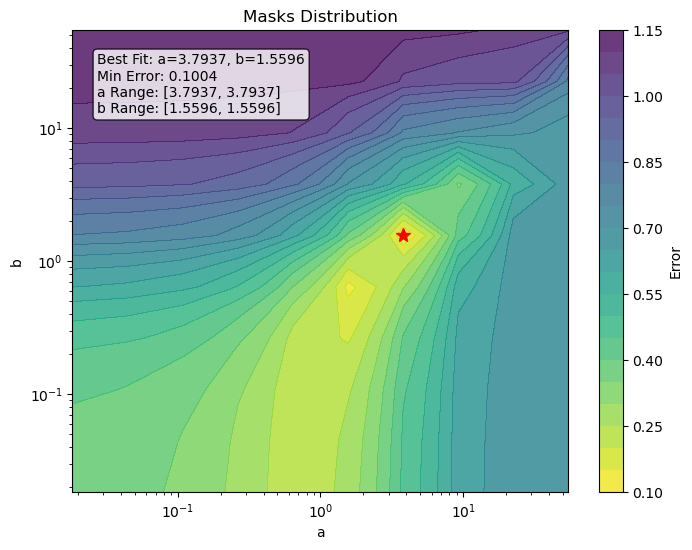

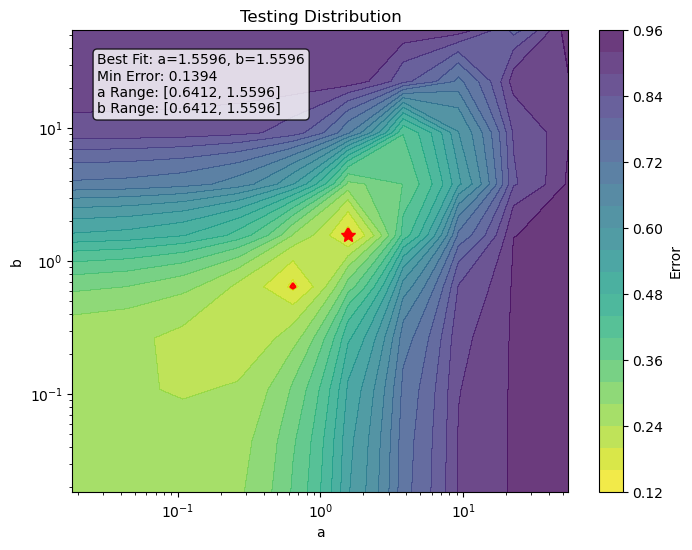

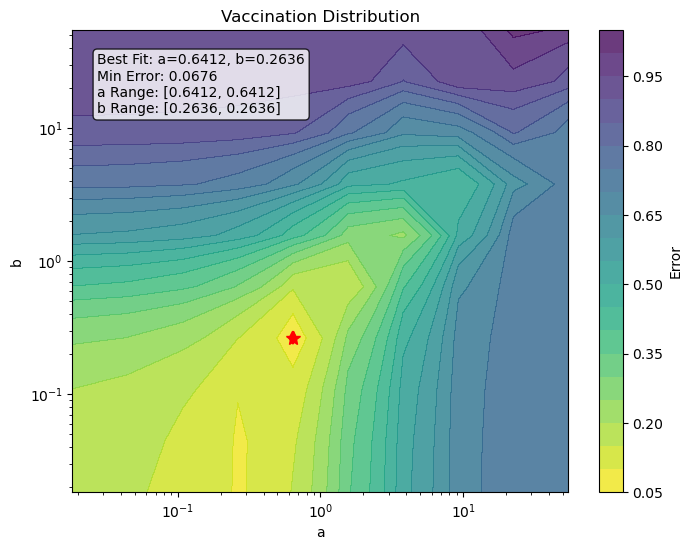

In [15]:
# Your existing code to create error matrices
a_range = np.exp(np.linspace(-4, 4, 10))
b_range = np.exp(np.linspace(-4, 4, 10))

ERRORS = np.zeros((len(a_range), len(b_range), 3))

for i, a in enumerate(a_range):
    for j, b in enumerate(b_range): 
        AB = my_beta_asymmetric(a, b, 5)
        ERRORS[i, j, 0] = matrix_l2_distance(AB, masks_distribution)
        ERRORS[i, j, 1] = matrix_l2_distance(AB, testing_distribution)
        ERRORS[i, j, 2] = matrix_l2_distance(AB, vacc_distribution)

# Transpose ERRORS to match the expected shape [behavior_type, a_idx, b_idx]
ERRORS_transposed = np.transpose(ERRORS, (2, 0, 1))

# Analyze the error matrices
results = analyze_behavior_error_matrices(
    a_range=a_range,
    b_range=b_range,
    error_matrices=ERRORS_transposed,
    confidence_threshold=0.1  # 10% threshold
)

# Print the results
for behavior, result in results.items():
    best_a, best_b = result["best_params"]
    a_min, _, a_max = result["confidence_intervals"]["param1"]
    b_min, _, b_max = result["confidence_intervals"]["param2"]
    
    print(f"\n{behavior} Distribution:")
    print(f"  Best fit parameters: a = {best_a:.4f}, b = {best_b:.4f}")
    print(f"  Error: {result['min_error']:.6f}")
    print(f"  Confidence interval for a: ({a_min:.4f}, {a_max:.4f})")
    print(f"  Confidence interval for b: ({b_min:.4f}, {b_max:.4f})")

# Show all figures
plt.show()

In [16]:
def transform_confidence_to_mean_polarization(
    a_range: np.ndarray,
    b_range: np.ndarray,
    error_matrix: np.ndarray,
    confidence_threshold: float = 0.1,
    title: str = "Distribution Analysis",
    figsize: Tuple[int, int] = (8, 6)
) -> Tuple[plt.Figure, Dict[str, Any]]:
    """
    Transform error matrix from (a,b) space to (mean, polarization) space.
    
    Args:
        a_range: Range of 'a' parameter values
        b_range: Range of 'b' parameter values
        error_matrix: 2D matrix of errors
        confidence_threshold: Fractional threshold for confidence region
        title: Plot title
        figsize: Figure size
        
    Returns:
        Tuple of (figure, result_data)
    """
    # Get confidence region in (a,b) space
    ab_confidence = get_confidence_region(
        a_range, b_range, error_matrix, confidence_threshold
    )
    
    # Create meshgrid for a and b
    a_mesh, b_mesh = np.meshgrid(a_range, b_range, indexing='ij')
    
    # Calculate mean and polarization for all parameter combinations
    mean_mesh = a_mesh / (a_mesh + b_mesh)
    variance_mesh = (a_mesh * b_mesh) / ((a_mesh + b_mesh)**2 * (a_mesh + b_mesh + 1))
    polarization_mesh = 4 * variance_mesh
    
    # Get best fit parameters
    best_a, best_b = ab_confidence["best_params"]
    best_mean = best_a / (best_a + best_b)
    best_polarization = 4 * (best_a * best_b) / ((best_a + best_b)**2 * (best_a + best_b + 1))
    
    # Get confidence region mask
    confidence_mask = ab_confidence["confidence_region_mask"]
    
    # Extract mean and polarization values within confidence region
    conf_means = mean_mesh[confidence_mask]
    conf_polarizations = polarization_mesh[confidence_mask]
    
    # Calculate confidence intervals
    mean_min = np.min(conf_means) if len(conf_means) > 0 else best_mean
    mean_max = np.max(conf_means) if len(conf_means) > 0 else best_mean
    pol_min = np.min(conf_polarizations) if len(conf_polarizations) > 0 else best_polarization
    pol_max = np.max(conf_polarizations) if len(conf_polarizations) > 0 else best_polarization
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Scatter plot of all evaluated points
    sc = ax.scatter(
        mean_mesh.flatten(),
        polarization_mesh.flatten(),
        c=error_matrix.flatten(),
        cmap='viridis_r',
        alpha=0.6,
        s=20
    )
    
    # Plot confidence region
    ax.scatter(
        conf_means, 
        conf_polarizations,
        color='red',
        alpha=0.3,
        label=f"{confidence_threshold*100:.0f}% confidence region"
    )
    
    # Mark best fit
    ax.scatter(
        [best_mean],
        [best_polarization],
        color='red',
        marker='*',
        s=200,
        label=f"Best fit"
    )
    
    # Set axis labels and title
    ax.set_xlabel("Mean")
    ax.set_ylabel("Polarization")
    ax.set_title(title)
    
    # Add colorbar
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label('Error')
    
    # Add legend
    ax.legend()
    
    # Add info text
    info_text = (
        f"Best Fit: Mean={best_mean:.4f}, Polarization={best_polarization:.4f}\n"
        f"Mean Range: [{mean_min:.4f}, {mean_max:.4f}]\n"
        f"Polarization Range: [{pol_min:.4f}, {pol_max:.4f}]"
    )
    ax.text(
        0.05, 0.95, info_text, transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )
    
    # Create result dictionary
    result = {
        "best_params": (best_mean, best_polarization),
        "min_error": ab_confidence["min_error"],
        "confidence_intervals": {
            "mean": (mean_min, best_mean, mean_max),
            "polarization": (pol_min, best_polarization, pol_max)
        },
        "original_ab_confidence": ab_confidence
    }
    
    return fig, result

def analyze_mean_polarization_errors(
    a_range: np.ndarray,
    b_range: np.ndarray,
    error_matrices: np.ndarray,
    confidence_threshold: float = 0.1,
    behavior_names: list = ["Masks", "Testing", "Vaccination"]
) -> Dict[str, Any]:
    """
    Analyze error matrices in terms of mean and polarization.
    
    Args:
        a_range: Range of 'a' parameter values
        b_range: Range of 'b' parameter values
        error_matrices: 3D error matrix with shape [behavior_type, a_idx, b_idx]
        confidence_threshold: Fractional threshold for confidence region
        behavior_names: List of names for each behavior type
        
    Returns:
        Dictionary with analysis results for each behavior type
    """
    results = {}
    
    # Analyze each behavior type
    for i, name in enumerate(behavior_names):
        if i < error_matrices.shape[0]:
            error_matrix = error_matrices[i, :, :]
            
            fig, result = transform_confidence_to_mean_polarization(
                a_range, b_range, error_matrix,
                confidence_threshold=confidence_threshold,
                title=f"{name} Distribution"
            )
            
            result["figure"] = fig
            results[name] = result
    
    return results


Masks Distribution:
  Best fit: Mean = 0.7087, Polarization = 0.1300
  Mean range: (0.7087, 0.7087)
  Polarization range: (0.1300, 0.1300)

Testing Distribution:
  Best fit: Mean = 0.5000, Polarization = 0.2428
  Mean range: (0.5000, 0.5000)
  Polarization range: (0.2428, 0.4381)

Vaccination Distribution:
  Best fit: Mean = 0.7087, Polarization = 0.4336
  Mean range: (0.7087, 0.7087)
  Polarization range: (0.4336, 0.4336)


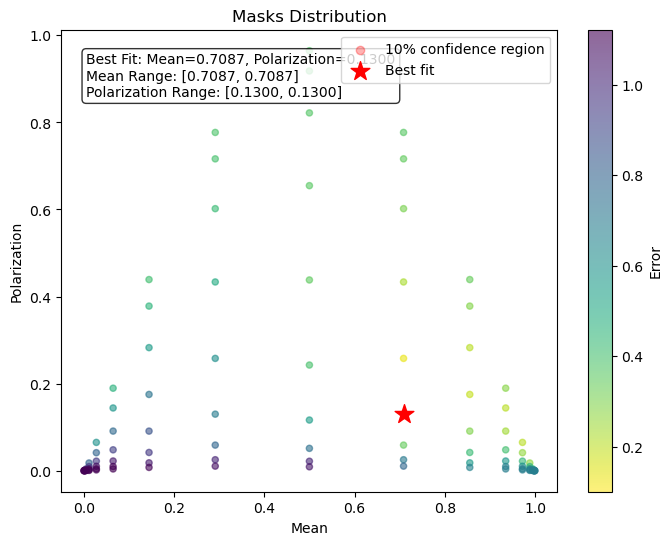

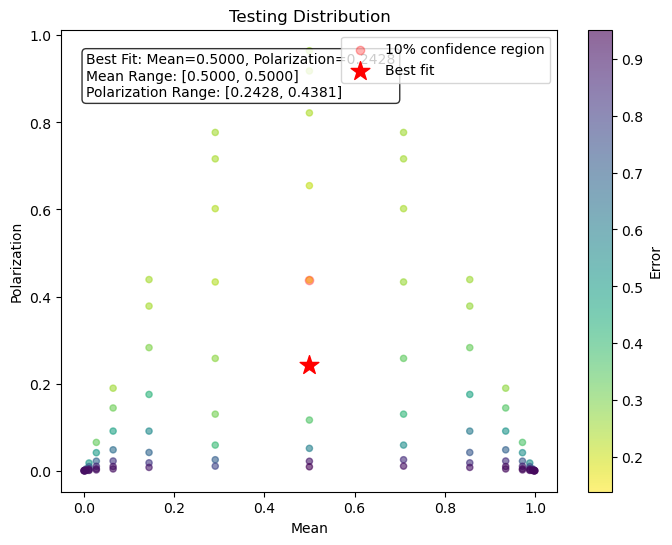

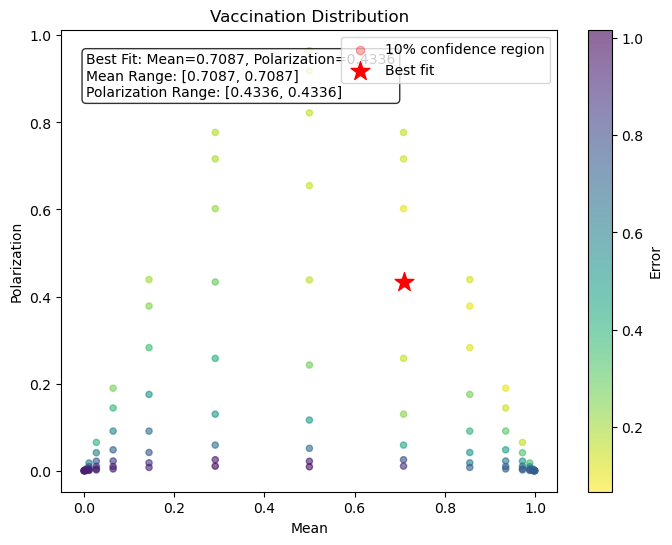

In [17]:
# Use the same error matrices created earlier
mean_pol_results = analyze_mean_polarization_errors(
    a_range=a_range,
    b_range=b_range,
    error_matrices=ERRORS_transposed,
    confidence_threshold=0.1
)

# Print the results
for behavior, result in mean_pol_results.items():
    best_mean, best_pol = result["best_params"]
    mean_min, _, mean_max = result["confidence_intervals"]["mean"]
    pol_min, _, pol_max = result["confidence_intervals"]["polarization"]
    
    print(f"\n{behavior} Distribution:")
    print(f"  Best fit: Mean = {best_mean:.4f}, Polarization = {best_pol:.4f}")
    print(f"  Mean range: ({mean_min:.4f}, {mean_max:.4f})")
    print(f"  Polarization range: ({pol_min:.4f}, {pol_max:.4f})")

# Show all figures
plt.show()

In [ ]:
def transform_confidence_to_mean_polarization(
    a_range: np.ndarray,
    b_range: np.ndarray,
    error_matrix: np.ndarray,
    confidence_threshold: float = 0.1,
    title: str = "Distribution Analysis",
    figsize: Tuple[int, int] = (8, 6)
) -> Tuple[plt.Figure, Dict[str, Any]]:
    """
    Transform error matrix from (a,b) space to (mean, polarization) space.
    
    Args:
        a_range: Range of 'a' parameter values
        b_range: Range of 'b' parameter values
        error_matrix: 2D matrix of errors
        confidence_threshold: Fractional threshold for confidence region
        title: Plot title
        figsize: Figure size
        
    Returns:
        Tuple of (figure, result_data)
    """
    # Get confidence region in (a,b) space
    ab_confidence = get_confidence_region(
        a_range, b_range, error_matrix, confidence_threshold
    )
    
    # Create meshgrid for a and b
    a_mesh, b_mesh = np.meshgrid(a_range, b_range, indexing='ij')
    
    # Calculate mean and polarization for all parameter combinations
    mean_mesh = a_mesh / (a_mesh + b_mesh)
    variance_mesh = (a_mesh * b_mesh) / ((a_mesh + b_mesh)**2 * (a_mesh + b_mesh + 1))
    polarization_mesh = 4 * variance_mesh
    
    # Get best fit parameters
    best_a, best_b = ab_confidence["best_params"]
    best_mean = best_a / (best_a + best_b)
    best_polarization = 4 * (best_a * best_b) / ((best_a + best_b)**2 * (best_a + best_b + 1))
    
    # Get confidence region mask
    confidence_mask = ab_confidence["confidence_region_mask"]
    
    # Extract mean and polarization values within confidence region
    conf_means = mean_mesh[confidence_mask]
    conf_polarizations = polarization_mesh[confidence_mask]
    
    # Calculate confidence intervals
    mean_min = np.min(conf_means) if len(conf_means) > 0 else best_mean
    mean_max = np.max(conf_means) if len(conf_means) > 0 else best_mean
    pol_min = np.min(conf_polarizations) if len(conf_polarizations) > 0 else best_polarization
    pol_max = np.max(conf_polarizations) if len(conf_polarizations) > 0 else best_polarization
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Scatter plot of all evaluated points
    sc = ax.scatter(
        mean_mesh.flatten(),
        polarization_mesh.flatten(),
        c=error_matrix.flatten(),
        cmap='viridis_r',
        alpha=0.6,
        s=20
    )
    
    # Plot confidence region
    ax.scatter(
        conf_means, 
        conf_polarizations,
        color='red',
        alpha=0.3,
        label=f"{confidence_threshold*100:.0f}% confidence region"
    )
    
    # Mark best fit
    ax.scatter(
        [best_mean],
        [best_polarization],
        color='red',
        marker='*',
        s=200,
        label=f"Best fit"
    )
    
    # Set axis labels and title
    ax.set_xlabel("Mean")
    ax.set_ylabel("Polarization")
    ax.set_title(title)
    
    # Add colorbar
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label('Error')
    
    # Add legend
    ax.legend()
    
    # Add info text
    info_text = (
        f"Best Fit: Mean={best_mean:.4f}, Polarization={best_polarization:.4f}\n"
        f"Mean Range: [{mean_min:.4f}, {mean_max:.4f}]\n"
        f"Polarization Range: [{pol_min:.4f}, {pol_max:.4f}]"
    )
    ax.text(
        0.05, 0.95, info_text, transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )
    
    # Create result dictionary
    result = {
        "best_params": (best_mean, best_polarization),
        "min_error": ab_confidence["min_error"],
        "confidence_intervals": {
            "mean": (mean_min, best_mean, mean_max),
            "polarization": (pol_min, best_polarization, pol_max)
        },
        "original_ab_confidence": ab_confidence
    }
    
    return fig, result

def analyze_mean_polarization_errors(
    a_range: np.ndarray,
    b_range: np.ndarray,
    error_matrices: np.ndarray,
    confidence_threshold: float = 0.1,
    behavior_names: list = ["Masks", "Testing", "Vaccination"]
) -> Dict[str, Any]:
    """
    Analyze error matrices in terms of mean and polarization.
    
    Args:
        a_range: Range of 'a' parameter values
        b_range: Range of 'b' parameter values
        error_matrices: 3D error matrix with shape [behavior_type, a_idx, b_idx]
        confidence_threshold: Fractional threshold for confidence region
        behavior_names: List of names for each behavior type
        
    Returns:
        Dictionary with analysis results for each behavior type
    """
    results = {}
    
    # Analyze each behavior type
    for i, name in enumerate(behavior_names):
        if i < error_matrices.shape[0]:
            error_matrix = error_matrices[i, :, :]
            
            fig, result = transform_confidence_to_mean_polarization(
                a_range, b_range, error_matrix,
                confidence_threshold=confidence_threshold,
                title=f"{name} Distribution"
            )
            
            result["figure"] = fig
            results[name] = result
    
    return results

In [55]:
# Use the same error matrices created earlier
mean_pol_results = analyze_mean_polarization_errors(
    a_range=a_range,
    b_range=b_range,
    error_matrices=ERRORS_transposed,
    confidence_threshold=0.1
)

# Print the results
for behavior, result in mean_pol_results.items():
    best_mean, best_pol = result["best_params"]
    mean_min, _, mean_max = result["confidence_intervals"]["mean"]
    pol_min, _, pol_max = result["confidence_intervals"]["polarization"]
    
    print(f"\n{behavior} Distribution:")
    print(f"  Best fit: Mean = {best_mean:.4f}, Polarization = {best_pol:.4f}")
    print(f"  Mean range: ({mean_min:.4f}, {mean_max:.4f})")
    print(f"  Polarization range: ({pol_min:.4f}, {pol_max:.4f})")

# Show all figures
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 20 but corresponding boolean dimension is 10

In [32]:
a_range = np.exp(np.linspace(-4, 4, 10))
b_range = np.exp(np.linspace(-4, 4, 10))

ERRORS = np.zeros((len(a_range), len(b_range), 3))

for i, a in enumerate(a_range):
    for j, b in enumerate(b_range): 
        AB = my_beta_asymmetric(a,b,5)
        #print(a,b, AB)
        ERRORS[i, j, 0] = matrix_l2_distance(AB, masks_distribution)
        ERRORS[i, j, 1] = matrix_l2_distance(AB, testing_distribution)
        ERRORS[i, j, 2] = matrix_l2_distance(AB, vacc_distribution)
        
        #fig, ax = plt.subplots(figsize=(5, 5))
        #plt.plot(AB)
        #plt.plot(masks_distribution)


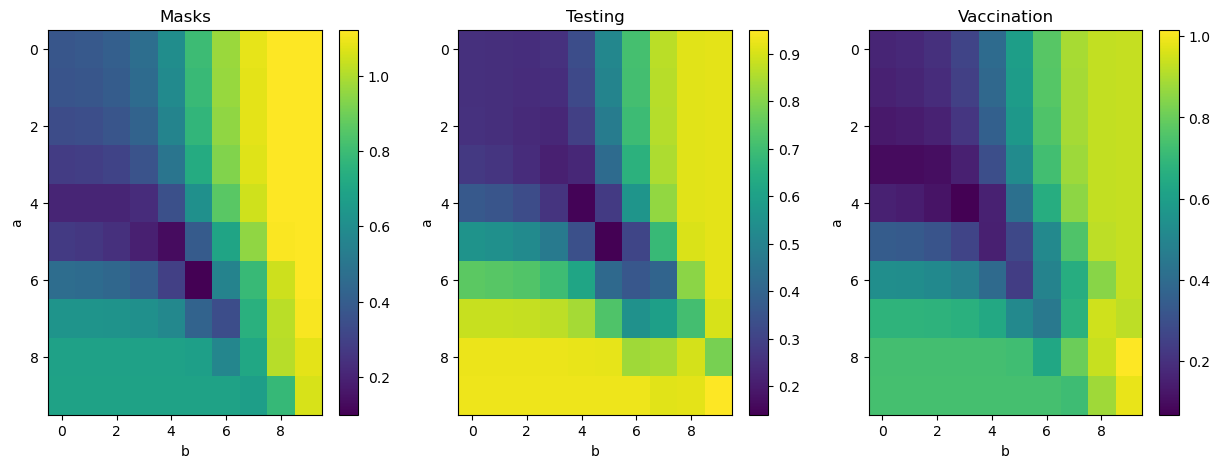

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    ax = axs[i]
    im = ax.imshow(ERRORS[:, :, i], cmap='viridis', aspect='auto')
    
    # Add colorbar
    plt.colorbar(im, ax=ax)
    
    # Set title
    if i == 0:
        ax.set_title('Masks')
    elif i == 1:
        ax.set_title('Testing')
    else:
        ax.set_title('Vaccination')
    ax.set_xlabel('b')
    ax.set_ylabel('a')